## Обработка изображений. Задание 2

__Володин Сергей__, группа 374

Цель работы: классификация геоглифов пустыни Наска.

 * Вход: изображения геоглифов (BMP)
 * Число классов: 7

Типы геоглифов:
 * Схематичный, неискаженный
 * Схематичный, искаженный
 * Фото со спутника

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io, morphology
from pandas import DataFrame as df
from scipy.ndimage.morphology import binary_fill_holes

# Загрузка изображений

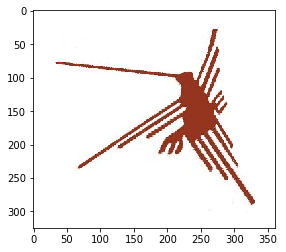

In [2]:
imc = skimage.io.imread_collection("Geogliph_1/*")
im = imc[1]
plt.imshow(im)

In [3]:
def binarize(im):
    im_gray = np.average(im, axis = 2)
    im_bin = 1. * (im_gray < 100)
    return(im_bin)
im_bin = binarize(im)

In [4]:
im_bin = binary_fill_holes(im_bin) * 1.
skimage.io.imsave('binarized.png', im_bin)

/home/sergei/Documents/jupyter/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


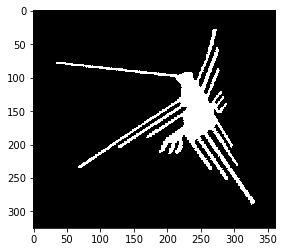

In [5]:
plt.imshow(im_bin, cmap = 'gray')

In [6]:
def skeletonize(im_bin):
    #im_sk = skimage.morphology.thin(im_bin)
    im_sk = skimage.morphology.skeletonize_3d(im_bin) / 255.
    return(im_sk)
im_sk = skeletonize(im_bin)

/home/sergei/Documents/jupyter/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


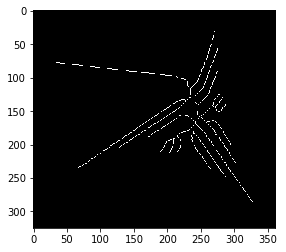

In [7]:
plt.imshow(im_sk, cmap = 'gray')

In [8]:
skimage.io.imsave("skeleton.png", im_sk * 1.)

In [9]:
def neighbours(im, i, j, step = 1):
    (x, y) = im.shape
    return im[max(0, i - step):min(i + step + 1, x),max(0, j - step):min(j + step + 1, y)]

In [10]:
def count_neighbours(im):
    res = np.zeros(9)
    
    neighbours_arr = np.zeros(im.shape)
    
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if im[i][j] > 0:
                neighbours_arr[i][j] = int(max(np.sum(neighbours(im, i, j)) - 1, 0))

    return neighbours_arr

In [11]:
def get_leaves(n_arr):
    mask = 1. * (n_arr == 1)
    return np.sum(mask), mask

def get_intersections(n_arr):
    mask = 1. * (n_arr > 2)
    result = np.zeros(n_arr.shape)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j] and np.sum(neighbours(result, i, j, 3)) == 0:
                result[i][j] = 1
    return np.sum(result), result

In [12]:
def get_preview(im_sk):
    n_arr = count_neighbours(im_sk)
    _, m_l = get_leaves(n_arr)
    _, m_i = get_intersections(n_arr)
    res = np.zeros((im_sk.shape[0], im_sk.shape[1], 3))
    res[:, :, 2] = im_sk * 1.
    res[:, :, 0] = m_l * 1.
    res[:, :, 1] = m_i * 1.
    return(res)

/home/sergei/Documents/jupyter/local/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: preview.png is a low contrast image
  warn('%s is a low contrast image' % fname)


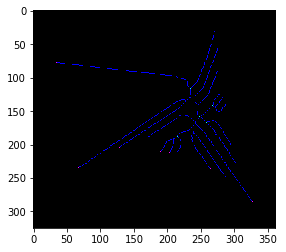

In [13]:
preview = get_preview(im_sk)
skimage.io.imsave('preview.png', preview)
plt.imshow(preview)

In [14]:
def get_features(im):
    im_sk = skeletonize(binarize(im))
    n_arr = count_neighbours(im_sk)
    c_l, _ = get_leaves(n_arr)
    c_i, _ = get_intersections(n_arr)
    return c_l, c_i

# Training classifier

In [15]:
num_per_class = 4
N = len(imc.files)

In [16]:
features = np.zeros((N, 2))
labels = np.zeros((N, ))

In [17]:
for i in range(N):
    print imc.files[i]
    features[i] = get_features(imc[i])
    labels[i] = i / num_per_class

Geogliph_1/Силуэт_1.bmp
Geogliph_1/Силуэт_1_2.bmp
Geogliph_1/Силуэт_1_3.bmp
Geogliph_1/Силуэт_1_4.bmp
Geogliph_1/Силуэт_2.bmp
Geogliph_1/Силуэт_2_2.bmp
Geogliph_1/Силуэт_2_3.bmp
Geogliph_1/Силуэт_2_4.bmp
Geogliph_1/Силуэт_3.bmp
Geogliph_1/Силуэт_3_2.bmp
Geogliph_1/Силуэт_3_3.bmp
Geogliph_1/Силуэт_3_4.bmp
Geogliph_1/Силуэт_4.bmp
Geogliph_1/Силуэт_4_2.bmp
Geogliph_1/Силуэт_4_3.bmp
Geogliph_1/Силуэт_4_4.bmp
Geogliph_1/Силуэт_5.bmp
Geogliph_1/Силуэт_5_2.bmp
Geogliph_1/Силуэт_5_3.bmp
Geogliph_1/Силуэт_5_4.bmp
Geogliph_1/Силуэт_6.bmp
Geogliph_1/Силуэт_6_2.bmp
Geogliph_1/Силуэт_6_3.bmp
Geogliph_1/Силуэт_6_4.bmp
Geogliph_1/Силуэт_7.bmp
Geogliph_1/Силуэт_7_2.bmp
Geogliph_1/Силуэт_7_3.bmp
Geogliph_1/Силуэт_7_4.bmp


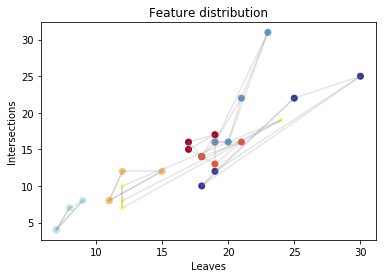

In [33]:
plt.scatter(features[:,0], features[:,1], c = labels, cmap = plt.cm.get_cmap('RdYlBu'))
plt.title('Feature distribution')
plt.xlabel('Leaves')
plt.ylabel('Intersections')
for i in range(N):
    p1 = (features[i,0], features[i,1])
    for j in range(N):
        p2 = (features[j,0], features[j,1])
        if labels[i] == labels[j]:
            plt.plot((p1[0], p2[0]), (p1[1], p2[1]), color='gray', alpha = 0.1)

In [ ]:
cmap = {0: ''}